### PCAM Eksperymenty - Seria 1

### Wspólne

In [1]:
# Tego nie odpalać -- to przeładuje moduły wszystkie i potencjalnie zresetuje LazyLoadera
# Nie ruszać chyba, że wiecie co robicie

# %load_ext autoreload
# %autoreload 0

In [1]:
import sys
sys.path.append("../..")

In [2]:
import torch
import torch.nn.functional as F
import torchvision.transforms as T

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import src.modules.data_module as dm
import src.modules.learner_module as lm
import src.modules.evaluation_module as em
import src.modules.pipeline as pp

import src.models as models

dm.update_data_dir('../../data')
device = (
    "cuda" if torch.cuda.is_available() else "cpu"
)
print(f"Using {device} device")

Initialising Lazy Loader (PCAMLL)
Default data directory set to c:\MyRoot\PWFiles\semestr 6\WB\wb-active-learning\notebooks\common\data
To change this path, use the update_data_dir() function from the data_module
Data directory set to: c:\MyRoot\PWFiles\semestr 6\WB\wb-active-learning\data
Using cuda device


### Experiments to Conduct
- mean accuracy for 50/100/250/500 random samples (both balanced and unbalanced) (N = 100, 100, 50, 20)
- AL_10_45_2_balanced (N >= 100)
- AL_10_45_2_ubalanced (N >= 100)

**Progress**
- [ ][ ] 50 (un)balanced
- [x][ ] 100 (un)balanced
- [ ][ ] 250 (un)balanced
- [x][ ] 500 (un)balanced

### Experiment Setup

**Random Unbalanced**

In [ ]:
experiment_balanced = False
N = 100
n_queries = 0
query_batch_size = 0
settings = pp.PipelineSettings(n_queries, 50, 50, query_batch_size, 'confidence')
train_size = 250
ratio_labeled = 1.0
test_size = 1_000
loss_fn = F.cross_entropy
experiment_name = f'{train_size}_full_balanced'

**Random Balanced**

In [ ]:
experiment_balanced = True
N = 100
n_queries = 0
query_batch_size = 0
settings = pp.PipelineSettings(n_queries, 50, 50, query_batch_size, 'confidence')
train_size = 250
ratio_labeled = 1.0
test_size = 1_000
loss_fn = F.cross_entropy
experiment_name = f'{train_size}_full_balanced'

**Active Learning 10_45_2 (Unbalanced)**

In [ ]:
experiment_name = '10_45_2_full'
experiment_balanced = False
N = 10
n_queries = 45
query_batch_size = 2
settings = pp.PipelineSettings(n_queries, 50, 50, query_batch_size, 'confidence')
train_size = 30_000
ratio_labeled = 0.000334
test_size = 1_000
loss_fn = F.cross_entropy

**Active Learning 10_45_2 (Balanced)**

In [ ]:
experiment_name = '10_45_2_full_balanced'
experiment_balanced = True
N = 10
n_queries = 45
query_batch_size = 2
settings = pp.PipelineSettings(n_queries, 50, 50, query_batch_size, 'confidence')
train_size = 30_000
ratio_labeled = 0.000334
test_size = 1_000
loss_fn = F.cross_entropy

**Test (Ignore)**

In [3]:
experiment_name = '10_45_2_full_balanced'
N = 4
n_queries = 45
query_batch_size = 2
settings = pp.PipelineSettings(n_queries, 50, 50, query_batch_size, 'confidence')
train_size = 30_000
ratio_labeled = 0.000334
test_size = 1_000
loss_fn = F.cross_entropy

### Experiment

In [41]:
import time
dynamic_allocation = True   # Zalecane teraz gdy używamy 96x96
reset_on_every_trial = True # Zalecane teraz gdy używamy 96x96
allow_cooldown = True       # Zalecane jeśli wam się rozgrzewa komputer

In [ ]:
evaluation = em.Evaluation(262144)
accuracy_history = np.zeros(shape=(N, n_queries + 1))

if dynamic_allocation:
    dm.PCAMLL.reset(train_idx=[], test_idx=[], val_idx=[])
else:
    # by default all these arguments are None
    # if None PCAMLL initialises them to full arrays (i.e. all indices)
    dm.PCAMLL.reset() # allocates memory for all of the data

for i in range(N):
    print(f"trial: {i + 1}")
    if i != 0:
        print("cooling down...")
        time.sleep(120)
        print("resuming work!")
    
    model = models.PCAMClassifier().to(device)
    learner = lm.ActiveLearner(model, device)
    optimizer = torch.optim.Adam(params=model.parameters())

    dataset = dm.ActiveDataset('pcam', train_size, test_size, ratio_labeled=ratio_labeled, balanced_split=experiment_balanced)
    if dynamic_allocation:
        if reset_on_every_trial:
            dm.PCAMLL.reset(train_idx=[], test_idx=[], val_idx=[])
        dm.PCAMLL.append_idx('train', dataset.train_subset_idx)
        dm.PCAMLL.append_idx('val', dataset.test_subset_idx)

    pipeline = pp.Pipeline(dataset, learner, optimizer, loss_fn, settings)
    session, stats = pipeline.run(verbose=1, calculate_accuracy=True)
    evaluation.append(session)
    accuracy_history[i,:] = stats['accuracy_history']

print("Saving results")
evaluation.to_csv(f"{experiment_name}_evaluation.csv")
np.save(f'{experiment_name}_accuracy_history', accuracy_history)

<Axes: >

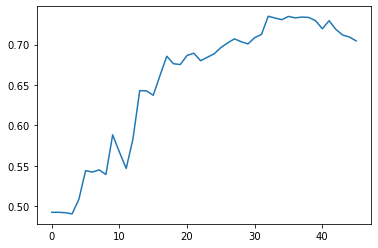

In [27]:
sns.lineplot(np.mean(accuracy_history, axis=0))